In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json
import os
import shutil
import random
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Définir les transformations pour les données
transform_couleur = transforms.Compose([
    transforms.Resize((112, 112)),  # Redimensionner les images à 112x112
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliser avec les statistiques de l'ImageNet
])

# Définir une nouvelle transformation pour convertir les images en niveaux de gris
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Redimensionner les images à 112x112
    transforms.Grayscale(),  # Convertir les images en niveaux de gris
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
])

# Télécharger et charger le jeu de données Flowers102
dataset = datasets.Flowers102(root='./data', 
                              split='train', 
                              transform=transform_couleur, 
                              download=True)

# Définir les proportions pour l'entraînement et le test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Diviser dataset1 en ensemble d'entraînement et de test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [3]:
print("nombre d'échantillons d'entraînement: " + str(len(train_dataset)) + "\n" +
      "nombre d'échantillons de test: " + str(len(test_dataset)))

nombre d'échantillons d'entraînement: 816
nombre d'échantillons de test: 204


In [4]:
print("type de données du 1er échantillon d'entraînement: ", train_dataset[0][0].type())
print("taille du 1er échantillon d'entraînement: ", train_dataset[0][0].size())

type de données du 1er échantillon d'entraînement:  torch.FloatTensor
taille du 1er échantillon d'entraînement:  torch.Size([3, 112, 112])


In [5]:
# Créer les DataLoader pour itérer sur les jeux de données
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Définir le modèle CNN

### Aplati pour 112 * 112 * 3

Pour améliorer la performance de notre réseau de neurones convolutifs (SimpleCNN) en utilisant des techniques similaires à celles utilisées dans ResNet, nous avons :

- Ajouter plus de couches convolutives avec des normalisations par lot et des activations.
- Utiliser des couches de pooling et de convolution pour réduire la dimensionnalité progressivement.
- Ajouter une architecture de type "Residual Block" pour faciliter l'apprentissage.

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(ImprovedCNN, self).__init__()
        self.in_channels = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(16, 32, stride=2)
        self.layer2 = self._make_layer(32, 64, stride=2)
        self.layer3 = self._make_layer(64, 128, stride=2)
        self.layer4 = self._make_layer(128, 256, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def _make_layer(self, in_channels, out_channels, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ImprovedCNN(num_classes=102)


In [8]:
# Définition de l'optimiseur et de la perte d'entropie croisée
optimiseur = torch.optim.Adam(model.parameters(), lr=0.001)
critere = nn.CrossEntropyLoss()

In [9]:
epochs = 25
Perte = []
acc = []


for epoque in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, etiquettes in train_loader:
        optimiseur.zero_grad()
        sorties = model(images)
        perte = critere(sorties, etiquettes)
        perte.backward()
        optimiseur.step()
        running_loss += perte.item()
    
    Perte.append(running_loss / len(train_loader))
    
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for images, etiquettes in test_loader:
            sorties = model(images)
            _, predit = torch.max(sorties.data, 1)
            total += etiquettes.size(0)
            correct += (predit == etiquettes).sum().item()
    
    precision = 100 * correct / total
    acc.append(precision)
    
    if epoque % 5 == 0:
        print(f'Époque : {epoque}, Perte : {running_loss / len(train_loader)}, Précision : {precision}')

print(f'Nombre d\'images dans le dataset original: {len(dataset)}')
print(f'Nombre d\'images dans le train_loader: {len(train_loader.dataset)}')
print(f'Nombre d\'images dans le test_loader: {len(test_loader.dataset)}')


Époque : 0, Perte : 4.54438147178063, Précision : 4.901960784313726
Époque : 5, Perte : 2.9598433788006124, Précision : 20.58823529411765
Époque : 10, Perte : 2.3383208238161526, Précision : 25.980392156862745
Époque : 15, Perte : 1.8792243462342482, Précision : 28.92156862745098
Époque : 20, Perte : 1.4534059304457445, Précision : 28.431372549019606
Nombre d'images dans le dataset original: 1020
Nombre d'images dans le train_loader: 816
Nombre d'images dans le test_loader: 204


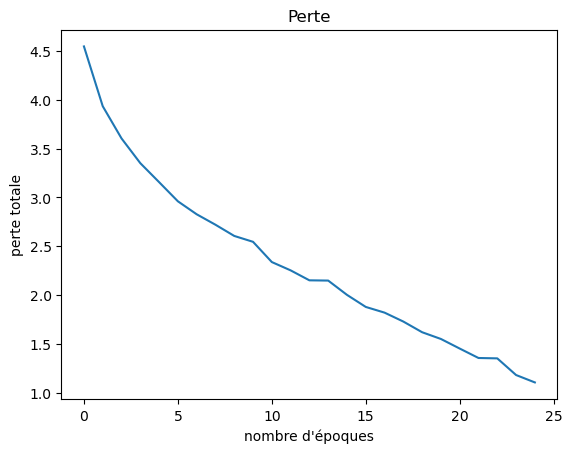

In [10]:
plt.plot(Perte)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()

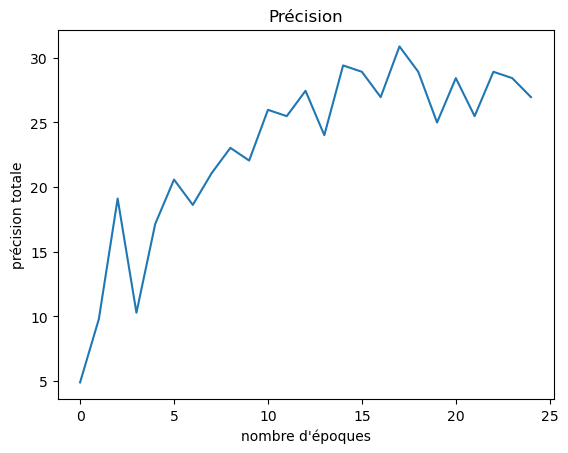

In [11]:
plt.plot(acc)
plt.xlabel("nombre d'époques")
plt.ylabel("précision totale")
plt.title("Précision")
plt.show()

In [12]:
import torch
import torchvision.models as models

# Définir des données factices en entrée
dummy_input = torch.randn(1, 3, 112, 112)  # Les dimensions correspondent à celles des données MNIST

# Spécifier le chemin de sauvegarde du modèle ONNX
onnx_path = "flower_model.onnx"

# Exporter le modèle en format ONNX
torch.onnx.export(model, dummy_input, onnx_path)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
